# Tutorial for Data

이 Notebook에는 참가자 분들께서 kspace, image data를 보다 쉽게 분석하실 수 있도록 간단한 시각화 예제를 첨부하였습니다.

## Setup

아래 코드를 실행하기 전, 필요한 module을 import합니다.

In [1]:
# Set up the environment for running a Python script that uses OpenCV and other libraries
!apt update
!apt install -y libgl1

# Install necessary Python packages
%pip install numpy matplotlib h5py opencv-python

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease               
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease                     
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease      
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
127 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1 is already the newest version (1.4.0-1).
0 upgraded, 0 newly installed, 0 to remove and 127 not upgraded.
Note: you may need to restart the kernel to use updated packages.


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2

## K-space data

kspace data를 담고 있는 h5 file은 아래와 같이 `kspace`, `mask`의 2가지 key를 갖습니다.
- `kspace`: kspace data. (shape: `(slices, coils, height, width)`)
- `mask`: kspace data를 undersampling하기 위한 mask. (shape: `(width, )`)

In [19]:
in_dir = "/root/Data/train/kspace/brain_acc4_1.h5"
kspace_f = h5py.File(in_dir)
kspace_f.keys()

<KeysViewHDF5 ['kspace', 'mask']>

In [57]:
kspace = kspace_f['kspace']
mask = kspace_f['mask']
print(kspace.shape, mask.shape)

(16, 16, 768, 396) (396,)


(16, 16, 768, 396) (396,)
torch.Size([16, 16, 768, 396, 2])
torch.Size([16, 16, 768, 396, 2])
torch.Size([16, 768, 396])
torch.Size([16, 384, 384])


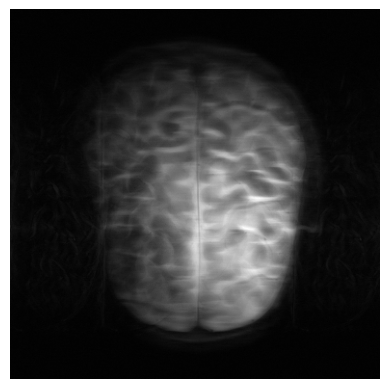

In [73]:
from fastmri import fft2c, ifft2c, rss_complex, complex_abs
import torch
import numpy as np
from utils.common.utils import center_crop
import torchvision.transforms.functional as TF

kspace = kspace_f['kspace']
mask = kspace_f['mask']
print(kspace.shape, mask.shape)
mask = np.array(mask)
kspace = kspace * mask.reshape(1,1,1,-1)
kspace = torch.from_numpy(kspace)
kspace = torch.stack((kspace.real, kspace.imag), dim=-1)
print(kspace.shape)
im = ifft2c(kspace)
print(im.shape)
im = rss_complex(im)
print(im.shape)
im = center_crop(im, 384, 384)
print(im.shape)
aug_im = TF.hflip(im)
im = im.cpu().numpy()
aug_im = aug_im.cpu().numpy()
plt.figure()
plt.axis('off')
plt.imshow(im[0], cmap='gray')

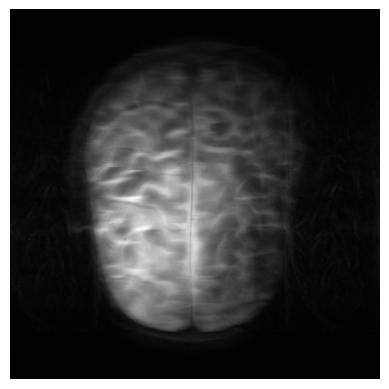

In [74]:
plt.figure()
plt.axis('off')
plt.imshow(aug_im[0], cmap='gray')

이제 kspace data를 시각화 해보겠습니다.

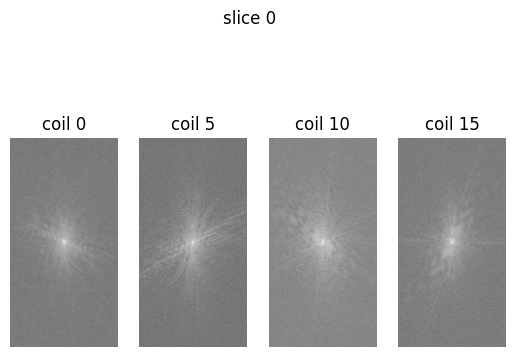

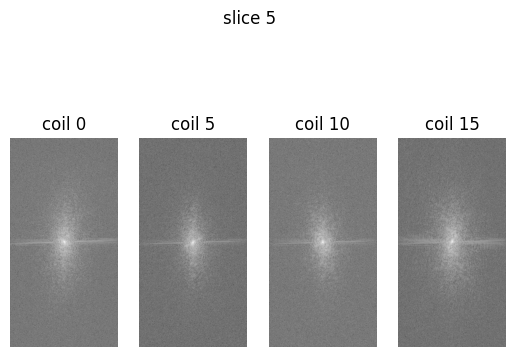

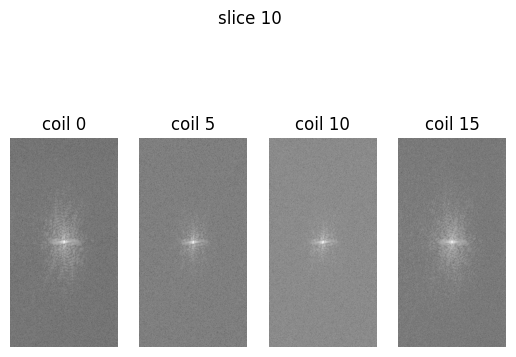

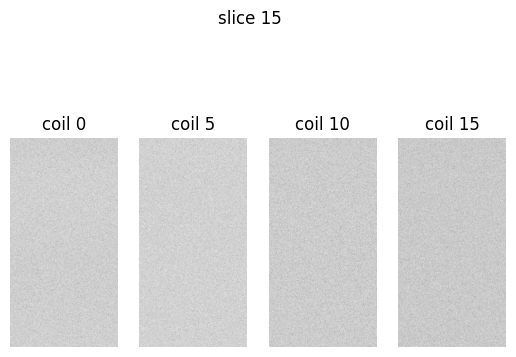

In [4]:
slice_len = kspace.shape[0]
for slice_idx in range(0, slice_len, 5):
    # convert kspace slice to real image
    kspace_slice = kspace[slice_idx]
    kspace_slice = np.log(np.abs(kspace_slice) + 1e-9)

    plt.figure()
    plt.suptitle(f'slice {slice_idx}')
    coil_len = kspace_slice.shape[0]
    for i, coil_idx in enumerate(range(0, coil_len, 5)):
        ax = plt.subplot(1, coil_len // 5 + 1, i + 1)
        plt.title(f'coil {coil_idx}')
        ax.imshow(kspace_slice[coil_idx], cmap='gray')
        plt.axis('off')  # Remove axes for a cleaner look

    plt.show()

위에서 확인하실 수 있듯, 본 challenge에서 다루는 data는 *multi-coil* data입니다. \
그러므로 하나의 slice에 대하여 서로 다른 coil로 얻어진 kspace data가 존재합니다. \
이들에 각각 inverse fourier transform을 취한 뒤, RSS(*root sum squared*) 연산을 취해 하나의 reconstruction image를 얻는 것입니다.

In [5]:
kspace_f.close()

## Image data (brain)

image data를 담고 있는 h5 file은 아래와 같이 `image_grappa`, `image_input`, `image_label`의 3가지 key를 갖습니다.
- `image_grappa`: _GRAPPA method_*를 사용하여 reconstruct한 image
- `image_input`: undersampled kspace data로부터 얻은 **aliased** image
- `image_label`: fully-sampled kspace data로부터 얻은 **aliasing free** image

각 파일에 대해, 세 이미지의 shape는 모두 `(slices, height, width)` 로 동일합니다. \
(*GRAPPA method에 관해서는 본 Challenge의 youtube channel에 설명 영상이 업로드되어 있습니다.)

In [6]:
in_dir = "/root/Data/train/image/brain_acc4_2.h5"
image_f = h5py.File(in_dir)
image_f.keys()

<KeysViewHDF5 ['image_grappa', 'image_input', 'image_label']>

In [7]:
image_grappa = image_f['image_grappa']
image_input = image_f['image_input']
image_label = image_f['image_label']
print(image_grappa.shape, image_input.shape, image_label.shape)

(16, 384, 384) (16, 384, 384) (16, 384, 384)


이제 image data를 시각화 해보겠습니다.

In [51]:
np.iscomplexobj(image_label[0])

False

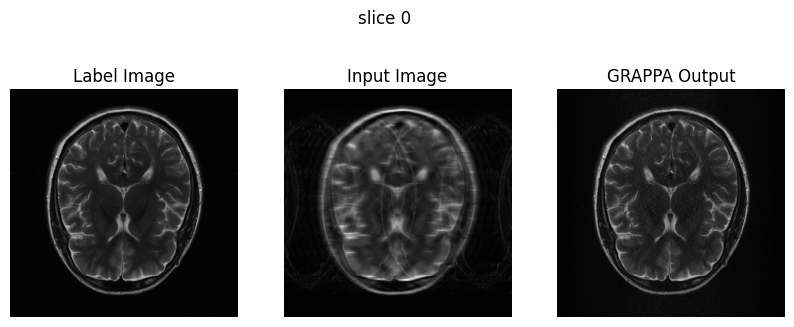

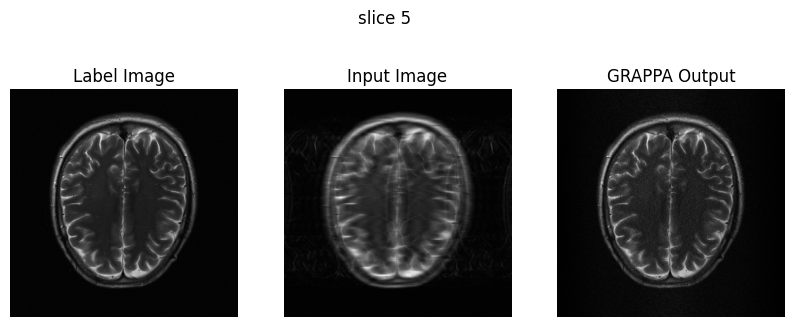

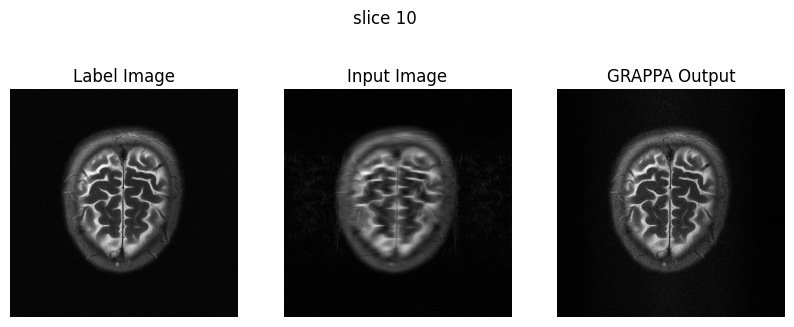

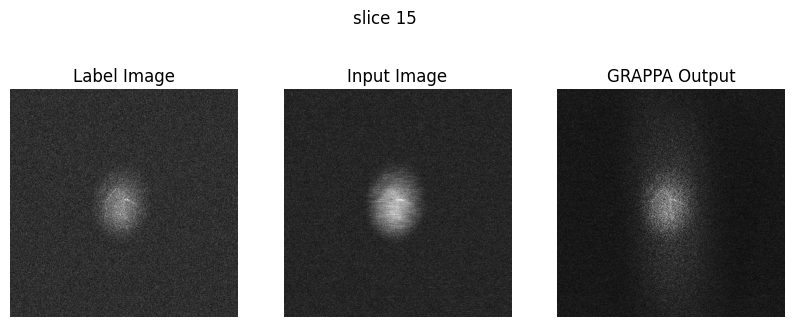

In [8]:
for slice_idx in range(0, image_label.shape[0], 5):
    plt.figure(figsize=(10, 4))
    plt.suptitle(f'slice {slice_idx}')

    ax = plt.subplot(1, 3, 1)
    plt.imshow(image_label[slice_idx], cmap='gray')
    ax.set_title('Label Image')
    ax.axis('off')

    ax = plt.subplot(1, 3, 2)
    plt.imshow(image_input[slice_idx], cmap='gray')
    ax.set_title('Input Image')
    ax.axis('off')

    ax = plt.subplot(1, 3, 3)
    plt.imshow(image_grappa[slice_idx], cmap='gray')
    ax.set_title('GRAPPA Output')
    ax.axis('off')

    plt.show()

In [9]:
image_f.close()

## Image data (knee)

knee에 대한 kspace, image data도 brain과 파일 형식, shape 등은 동일합니다.

In [43]:
in_dir = "/root/Data/train/image/knee_acc4_1.h5"
image_f = h5py.File(in_dir)

image_grappa = image_f['image_grappa']
image_input = image_f['image_input']
image_label = image_f['image_label']

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


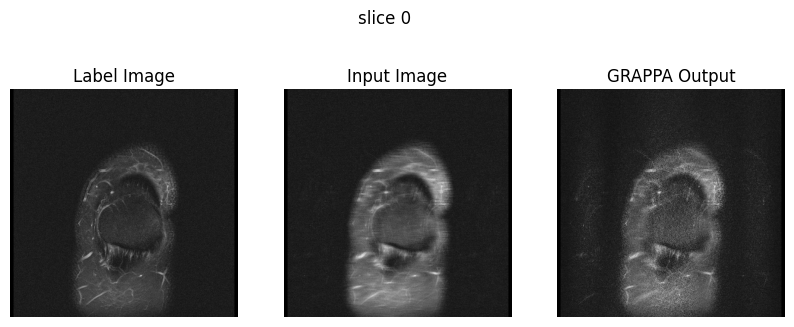

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


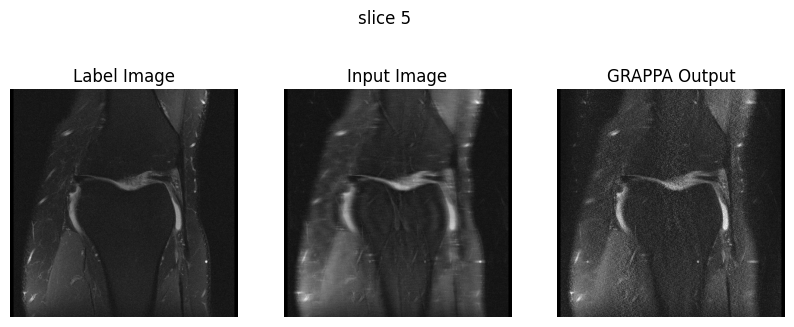

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


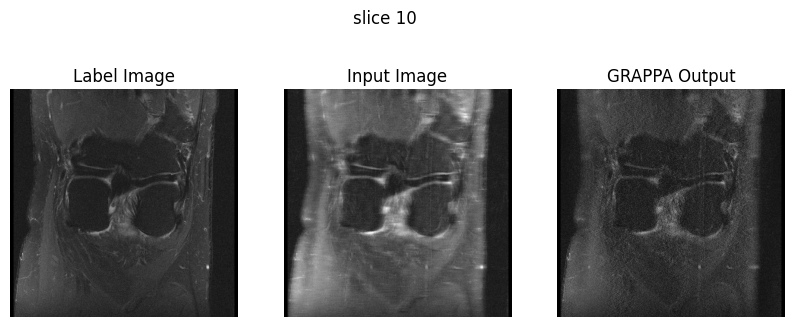

In [45]:
for slice_idx in range(0, image_label.shape[0], 5):
    print(image_label[0])
    plt.figure(figsize=(10, 4))
    plt.suptitle(f'slice {slice_idx}')
    ax = plt.subplot(1, 3, 1)
    plt.imshow(image_label[slice_idx], cmap='gray')
    ax.set_title('Label Image')
    ax.axis('off')

    ax = plt.subplot(1, 3, 2)
    plt.imshow(image_input[slice_idx], cmap='gray')
    ax.set_title('Input Image')
    ax.axis('off')

    ax = plt.subplot(1, 3, 3)
    plt.imshow(image_grappa[slice_idx], cmap='gray')
    ax.set_title('GRAPPA Output')
    ax.axis('off')

    plt.show()

In [12]:
image_f.close()